In [1]:
import json
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.impute import KNNImputer


np.random.seed(123)
sns.set_style('darkgrid')
pd.set_option('display.max_colwidth', None)

In [2]:
#define a function to read the features
def describe_column(meta):
    """
    Utility function for describing a dataset column (see below for usage)
    """
    def f(x):
        d = pd.Series(name=x.name, dtype=object)
        m = next(m for m in meta if m['name'] == x.name)
        d['Type'] = m['type']
        d['#NaN'] = x.isna().sum()
        d['Description'] = m['desc']
        if m['type'] == 'categorical':
            counts = x.dropna().map(dict(enumerate(m['cats']))).value_counts().sort_index()
            d['Statistics'] = ', '.join(f'{c}({n})' for c, n in counts.items())
        elif m['type'] == 'real' or m['type'] == 'integer':
            stats = x.dropna().agg(['mean', 'std', 'min', 'max'])
            d['Statistics'] = ', '.join(f'{s}={v :.1f}' for s, v in stats.items())
        elif m['type'] == 'boolean':
            counts = x.dropna().astype(bool).value_counts().sort_index()
            d['Statistics'] = ', '.join(f'{c}({n})' for c, n in counts.items())
        else:
            d['Statistics'] = f'#unique={x.nunique()}'
        return d
    return f

#define a function to read the statistical values di un df
def describe_data(data, meta):
    desc = data.apply(describe_column(meta)).T
    desc = desc.style.set_properties(**{'text-align': 'left'})
    desc = desc.set_table_styles([ dict(selector='th', props=[('text-align', 'left')])])
    return desc 

#define a function to compute the root mean square log error 
def root_mean_squared_log_error(y_true, y_pred):
    # Alternatively: sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5
    assert (y_true >= 0).all() 
    assert (y_pred >= 0).all()
    log_error = np.log1p(y_pred) - np.log1p(y_true)  # Note: log1p(x) = log(1 + x)
    return np.mean(log_error ** 2) ** 0.5

In [3]:
#description of the apartments
apartments = pd.read_csv('apartments_train.csv')
print(f'Loaded {len(apartments)} apartments')
with open('apartments_meta.json') as f: 
    apartments_meta = json.load(f)
describe_data(apartments, apartments_meta)

Loaded 23285 apartments


,Type,#NaN,Description,Statistics
id,integer_id,0,Unique ID for apartment,#unique=23285
seller,categorical,8830,The type of apartment seller,"Agents(1895), Company(4768), Developer(6185), Owner(1607)"
price,real,0,The listed price of the apartment (TARGET),"mean=23556173.5, std=52643927.8, min=900000.0, max=2600000000.0"
area_total,real,0,Total area of the apartment,"mean=74.5, std=58.7, min=9.3, max=2181.0"
area_kitchen,real,4721,Total kitchen area in the apartment,"mean=12.6, std=6.6, min=1.0, max=100.0"
area_living,real,3882,Total living space area in the apartment,"mean=38.7, std=31.4, min=0.0, max=900.0"
floor,integer,0,Primary building floor of the apartment,"mean=9.0, std=8.3, min=1.0, max=95.0"
rooms,integer,0,Number of rooms in the apartment,"mean=2.2, std=1.1, min=1.0, max=6.0"
layout,categorical,17642,Overal apartment layout,"Adjacent(241), Adjacent_isolated(465), Isolated(4937)"
ceiling,real,11093,Ceiling height in the apartment,"mean=3.3, std=10.8, min=0.0, max=340.0"


In [4]:
#description of the buildings
buildings = pd.read_csv('buildings_train.csv')
print(f'Loaded {len(buildings)} buildings')
with open('buildings_meta.json') as f: 
    buildings_meta = json.load(f)
buildings


Loaded 6791 buildings


,id,new,latitude,longitude,district,street,address,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
0,264,0.0,55.518117,37.355139,11.0,улица 1-я Нововатутинская,3,2019.0,2.0,12.0,1.0,1.0,1.0,0.0,1.0,3.0
1,6079,0.0,55.641920,37.352156,7.0,мкр. 10-й,к1014,1981.0,3.0,22.0,0.0,1.0,1.0,NaN,1.0,0.0
2,5829,0.0,55.770011,37.386220,7.0,Рублевское шоссе,68,2002.0,3.0,24.0,0.0,1.0,1.0,NaN,NaN,0.0
3,5758,0.0,55.739934,37.426070,7.0,Рублевское шоссе,93К2,2011.0,3.0,17.0,0.0,1.0,1.0,NaN,1.0,0.0
4,6761,0.0,55.649921,37.467994,7.0,улица Академика Анохина,58К2,2005.0,3.0,22.0,0.0,1.0,1.0,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6786,96,0.0,55.891077,37.651583,2.0,Широкая улица,1К5,1980.0,3.0,16.0,0.0,1.0,1.0,1.0,1.0,0.0
6787,5857,0.0,55.821755,37.652930,2.0,улица Космонавтов,5,1989.0,3.0,9.0,0.0,1.0,0.0,NaN,0.0,0.0
6788,5218,0.0,55.600694,37.366484,11.0,улица Лаптева,4,2017.0,3.0,17.0,0.0,1.0,1.0,1.0,1.0,0.0
6789,1346,0.0,55.598817,37.360196,11.0,улица Москвитина,5к1,2016.0,3.0,25.0,0.0,1.0,1.0,1.0,1.0,0.0


In [5]:
#merge the due dataset using the building_id 
print(f'All apartments have an associated building: {apartments.building_id.isin(buildings.id).all()}')
data = pd.merge(apartments, buildings.set_index('id'), how='left', left_on='building_id', right_index=True)
data

All apartments have an associated building: True


,id,seller,price,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,...,address,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
0,0,3.0,7139520.0,59.2,12.5,31.0,2.0,2.0,NaN,2.65,...,к2.5/2,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN
1,1,NaN,10500000.0,88.0,14.2,48.0,18.0,3.0,1.0,NaN,...,14к3,2010.0,3.0,25.0,0.0,1.0,1.0,1.0,NaN,0.0
2,2,3.0,9019650.0,78.5,22.5,40.8,12.0,3.0,NaN,2.65,...,38,2021.0,3.0,15.0,0.0,1.0,1.0,1.0,NaN,NaN
3,3,NaN,10500000.0,88.0,14.0,48.0,18.0,3.0,NaN,NaN,...,14к3,2010.0,3.0,25.0,0.0,1.0,1.0,1.0,NaN,0.0
4,4,NaN,13900000.0,78.0,17.0,35.0,7.0,2.0,1.0,2.90,...,1к3,2017.0,2.0,15.0,0.0,1.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23280,23280,NaN,13300000.0,65.0,16.0,32.0,3.0,2.0,NaN,3.00,...,70к6,2017.0,2.0,24.0,0.0,1.0,1.0,0.0,1.0,1.0
23281,23281,3.0,15854300.0,56.9,9.6,36.5,6.0,2.0,NaN,NaN,...,2/2,2020.0,2.0,20.0,0.0,1.0,0.0,0.0,NaN,NaN
23282,23282,NaN,19800000.0,73.4,23.0,29.3,16.0,2.0,NaN,NaN,...,4,2018.0,2.0,16.0,1.0,1.0,1.0,0.0,0.0,NaN
23283,23283,0.0,29999000.0,100.8,20.0,NaN,4.0,3.0,NaN,NaN,...,39К1,1997.0,2.0,10.0,0.0,1.0,1.0,0.0,NaN,0.0


In [6]:
#do the same process with the data_test
apartments_test = pd.read_csv('apartments_test.csv')
buildings_test = pd.read_csv('buildings_test.csv')
print(f'All test apartments have an associated building: {apartments_test.building_id.isin(buildings_test.id).all()}')
data_test = pd.merge(apartments_test, buildings_test.set_index('id'), how='left', left_on='building_id', right_index=True)
print(f'Number of train samples: {len(data)}')
print(f'Number of test samples:  {len(data_test)}')
data_test.head()

All test apartments have an associated building: True
Number of train samples: 23285
Number of test samples:  9937


,id,seller,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,bathrooms_shared,...,address,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
0,23285,NaN,71.4,NaN,NaN,2.0,1.0,NaN,NaN,NaN,...,6к3,2017.0,2.0,20.0,1.0,1.0,1.0,NaN,1.0,0.0
1,23286,NaN,54.0,4.0,50.0,4.0,1.0,NaN,3.00,NaN,...,3к2,2017.0,2.0,15.0,0.0,1.0,1.0,0.0,0.0,0.0
2,23287,3.0,39.4,19.6,11.2,10.0,1.0,NaN,2.65,1.0,...,27,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN
3,23288,NaN,60.9,NaN,NaN,5.0,2.0,1.0,NaN,1.0,...,23,2014.0,2.0,17.0,1.0,1.0,0.0,NaN,1.0,3.0
4,23289,NaN,34.0,9.0,17.0,14.0,1.0,NaN,2.75,1.0,...,13к1,2016.0,2.0,17.0,0.0,1.0,1.0,NaN,1.0,0.0


 # Duplicated values

In [7]:
#detect the possible duplicated values inside our dataset and delete them in the case (by comparing the shape before and then):

""" data.duplicated() """

' data.duplicated() '

In [8]:
""" print(data.shape)
data.drop_duplicates(inplace=True)
print(data.shape) """

#same shape --> there weren't duplicated values inside the dataset.

' print(data.shape)\ndata.drop_duplicates(inplace=True)\nprint(data.shape) '

In [9]:
""" data_test.duplicated() """

' data_test.duplicated() '

In [10]:
""" print(data_test.shape)
data_test.drop_duplicates(inplace=True)
print(data_test.shape)
 """
#same shape --> there weren't duplicated values inside the dataset.

' print(data_test.shape)\ndata_test.drop_duplicates(inplace=True)\nprint(data_test.shape)\n '

DATA PREPROCESSING

In [11]:
#plot the vertical bar chart for all the numerical attributes
# data.hist(figsize=(20,20))

# Missing values

In [12]:
#point 2
# id feature is pointless for the analysis of the price since it changes for each sample
del data['id']
del data_test['id']


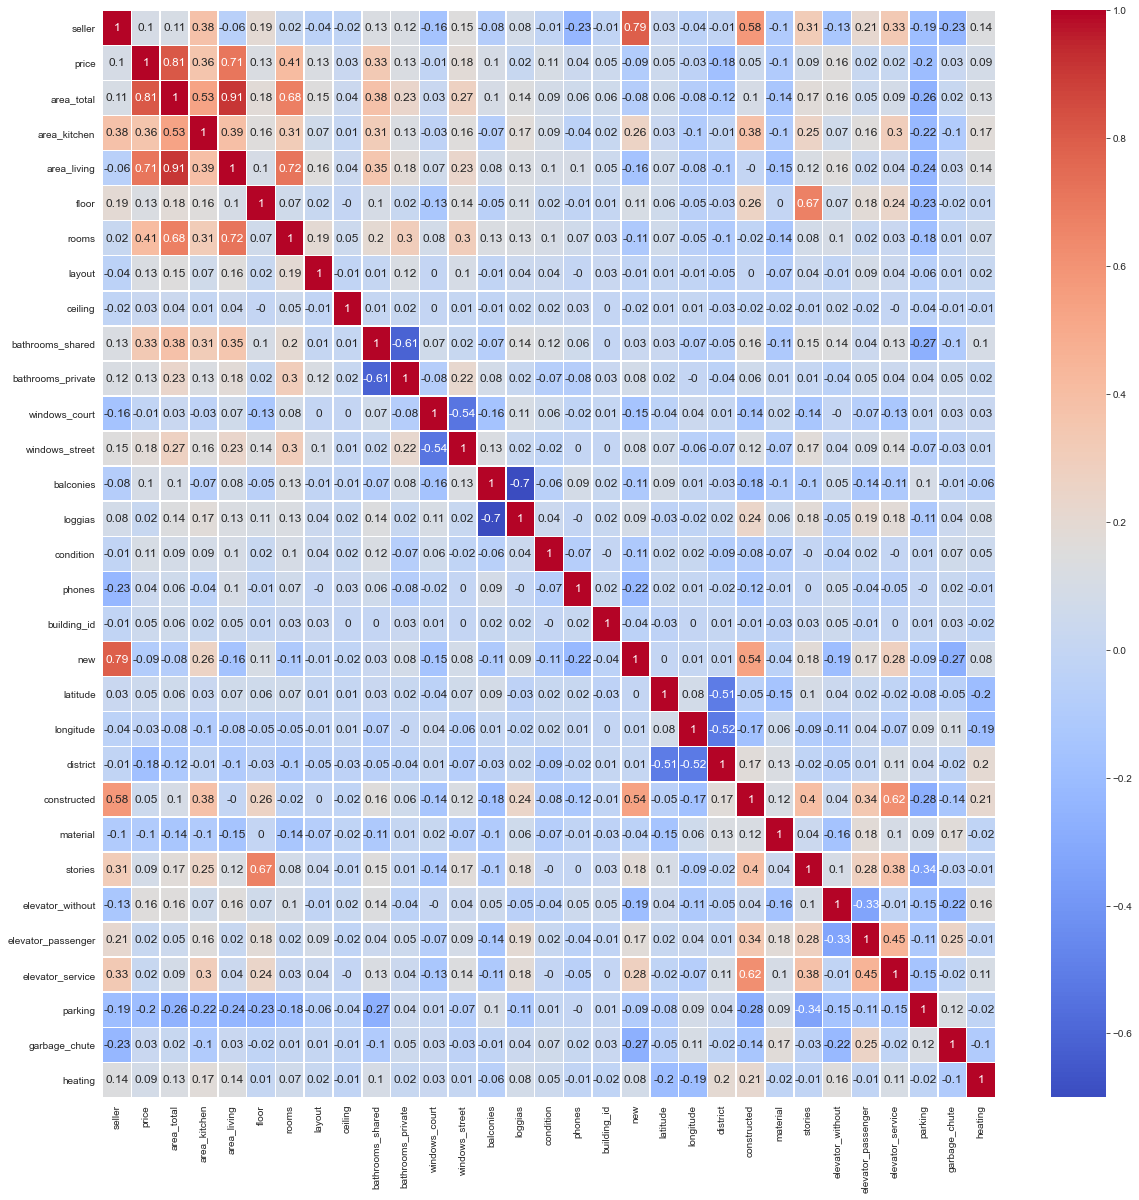

In [13]:
#heatmap
plt.figure(figsize = (20,20))
sns.heatmap(data=data.corr().round(2), cmap='coolwarm', linewidths=.5, annot=True, annot_kws={"size":12})
plt.show() 

In [14]:
#point 3
# layout is pointless because for the largest number of the samples this features is NaN
del data['layout']
del data_test['layout']


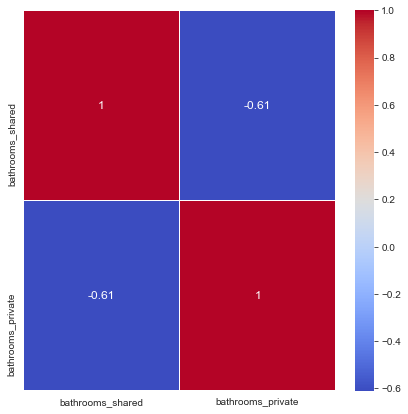

In [15]:
#point 5.a 
# firstly samples with NaN values for the features 'bathroom_shared' and 'bathroom_private' have been deleted and then the heatmap is displayed only for these two attributes
#bathroom_share is strongly correlated with bathroom_private: the coefficient is -0.61 (the correlation is inverse).
#so the feature 'bathrooms_shared' has been deleted. 
df = data[data['bathrooms_shared'].notna()]
df = df[df['bathrooms_private'].notna()]
prova=df[['bathrooms_shared','bathrooms_private']]
plt.figure(figsize = (7,7))
sns.heatmap(data=prova.corr().round(2), cmap='coolwarm', linewidths=.5, annot=True, annot_kws={"size":12})
plt.show()


In [16]:
del data["bathrooms_shared"]
del data_test["bathrooms_shared"]

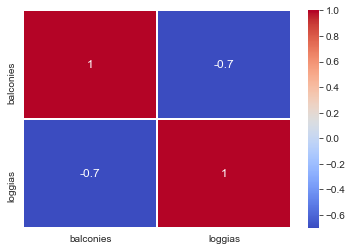

In [17]:
#point 5.b 
# firstly samples with NaN values for the features 'balconies' and 'loggias' have been deleted and then the heatmap is displayed only for these two attributes
#balconies is strongly correlated with loggias: the coefficient is -0.7(the correlation is inverse).
#so the feature 'loggias' has been deleted. 
df = data[data['balconies'].notna()]
df = df[df['loggias'].notna()]

prova=df[['balconies','loggias']]
sns.heatmap(data=prova.corr().round(2), cmap='coolwarm', linewidths=.5, annot=True, annot_kws={"size":12})
plt.show()


In [18]:
del data["loggias"]
del data_test["loggias"]


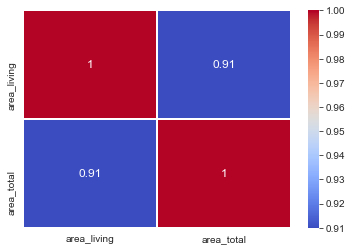

In [19]:
#point 5.c 

df = data[data['area_living'].notna()]
df = df[df['area_total'].notna()]

prova=df[['area_living','area_total']]
sns.heatmap(data=prova.corr().round(2), cmap='coolwarm', linewidths=.5, annot=True, annot_kws={"size":12})
plt.show()

In [20]:
del data["area_living"]
del data_test["area_living"]


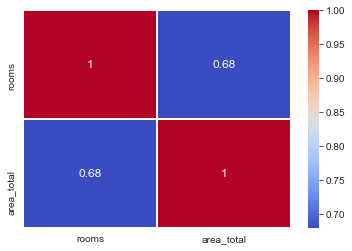

In [21]:
#point 5.d

df = data[data['rooms'].notna()]
df = df[df['area_total'].notna()]

prova=df[['rooms','area_total']]
sns.heatmap(data=prova.corr().round(2), cmap='coolwarm', linewidths=.5, annot=True, annot_kws={"size":12})
plt.show()

In [22]:
del data["rooms"]
del data_test["rooms"]

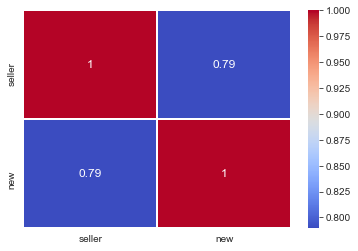

In [23]:
#point 5.e

df = data[data['seller'].notna()]
df = df[df['new'].notna()]

prova=df[['seller','new']]
sns.heatmap(data=prova.corr().round(2), cmap='coolwarm', linewidths=.5, annot=True, annot_kws={"size":12})
plt.show()

In [24]:
del data["seller"]
del data_test["seller"]

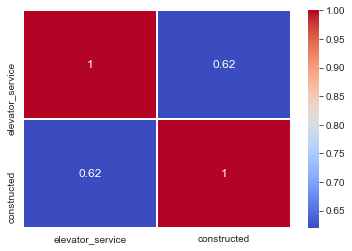

In [25]:
#point 5.f

df = data[data['elevator_service'].notna()]
df = df[df['constructed'].notna()]

prova=df[['elevator_service','constructed']]
sns.heatmap(data=prova.corr().round(2), cmap='coolwarm', linewidths=.5, annot=True, annot_kws={"size":12})
plt.show()

In [26]:
del data["elevator_service"]
del data_test["elevator_service"]

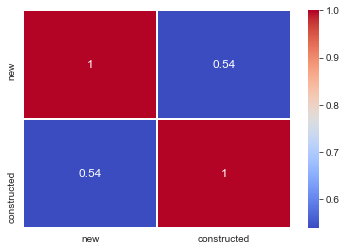

In [27]:
#point 5.g

df = data[data['new'].notna()]
df = df[df['constructed'].notna()]

prova=df[['new','constructed']]
sns.heatmap(data=prova.corr().round(2), cmap='coolwarm', linewidths=.5, annot=True, annot_kws={"size":12})
plt.show()

In [28]:
del data["constructed"]
del data_test["constructed"]

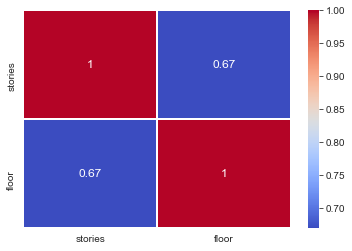

In [29]:
#point 5.h 

df = data[data['stories'].notna()]
df = df[df['floor'].notna()]

prova=df[['stories','floor']]
sns.heatmap(data=prova.corr().round(2), cmap='coolwarm', linewidths=.5, annot=True, annot_kws={"size":12})
plt.show()

In [30]:
del data["stories"]
del data_test["stories"]

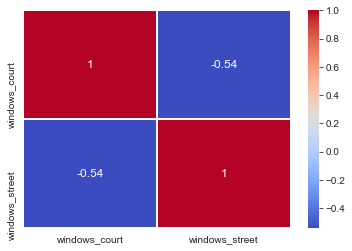

In [31]:
#point 5.i 

df = data[data['windows_court'].notna()]
df = df[df['windows_street'].notna()]

prova=df[['windows_court','windows_street']]
sns.heatmap(data=prova.corr().round(2), cmap='coolwarm', linewidths=.5, annot=True, annot_kws={"size":12})
plt.show()

In [32]:
del data["windows_court"]
del data_test["windows_court"]

In [33]:
#point 6
# new is useless because its distribution is almost unique (boolean value = false) and it is not correlated with the price feature
del data['new']
del data_test['new']

In [34]:
#point 7

data['heating']=data['heating'].fillna("Central")
data_test['heating']=data_test['heating'].fillna("Central")


In [35]:
#point 8,9
data = data[data['phones'].notna()]
data = data[data['elevator_passenger'].notna()]
data_test = data_test[data_test['phones'].notna()]
data_test = data_test[data_test['elevator_passenger'].notna()]


In [36]:
#point 10

In [37]:
# point 11
#ceiling
# for x in data.index:
#     k=data.loc[x]
#     if k["ceiling"] == NaN:
#         building=k["building_id"]
#         ceiling=k["ceiling"]
#         k["ceiling"].fillna(data_test['heating'].mode(), inplace=True)
#         building = row[“building_id”]
#         ceiling = data[“ceiling” where “building_id” == building]
#         row[“ceiling”] = ceiling
data = data.fillna(df['ceiling'].value_counts().index[0])
#data = data.fillna(df.mode().iloc[0])
data['building_id'].value_counts()


7203    143
4162    130
6703    127
8776    126
6512    122
       ... 
5636      1
7685      1
1542      1
3591      1
3782      1
Name: building_id, Length: 6486, dtype: int64

In [38]:
#point 12

In [39]:
#point 13 
data['parking']=data['parking'].fillna(3.0)
data_test['parking']=data_test['parking'].fillna(3.0)


In [40]:
#point 14
data['bathrooms_private'] = data['bathrooms_private'].astype(float)
data_test['bathrooms_private'] = data_test['bathrooms_private'].astype(float)
mean=data['bathrooms_private'].mean()
data['bathrooms_private']=data['bathrooms_private'].fillna('mean')
mean=data_test['bathrooms_private'].mean()
data_test['bathrooms_private']=data_test['bathrooms_private'].fillna('mean')

""" data.fillna(data.mean()[["bathrooms_private"]])
data_test.fillna(data_test.mean()[["bathrooms_private"]]) """

' data.fillna(data.mean()[["bathrooms_private"]])\ndata_test.fillna(data_test.mean()[["bathrooms_private"]]) '

In [41]:
#point 15

In [42]:
#point 16

data['elevator_passenger']=data['elevator_passenger'].fillna(-1.0)
data_test['elevator_passenger']=data_test['elevator_passenger'].fillna(-1.0)
data['elevator_without']=data['elevator_without'].fillna(-1.0)
data_test['elevator_without']=data_test['elevator_without'].fillna(-1.0)
data['garbage_chute']=data['garbage_chute'].fillna(-1.0)
data_test['garbage_chute']=data_test['garbage_chute'].fillna(-1.0)
data['windows_street']=data['windows_street'].fillna(-1.0)
data_test['windows_street']=data_test['windows_street'].fillna(-1.0)

In [43]:
#point 17

del data["material"]
del data_test["material"]

In [44]:
data = data[data['district'].notna()]
data_test = data_test[data_test['district'].notna()]

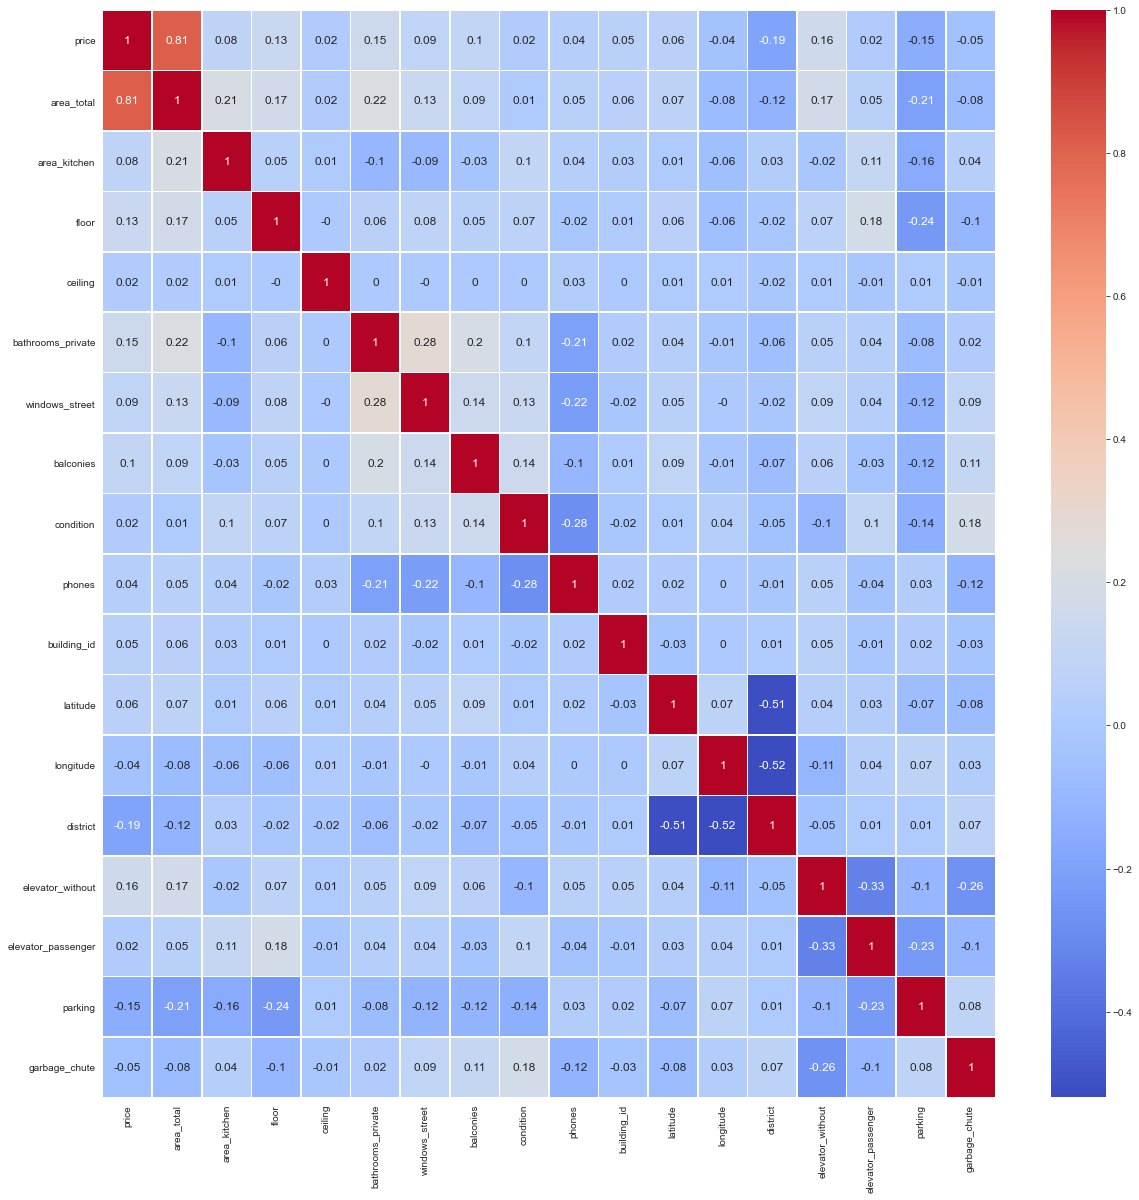

In [45]:
plt.figure(figsize = (20,20))
sns.heatmap(data=data.corr().round(2), cmap='coolwarm', linewidths=.5, annot=True, annot_kws={"size":12})
plt.show() 

In [46]:
#point 18

data_test = data_test[data_test['longitude'].notna()]
data_test = data_test[data_test['latitude'].notna()]


In [47]:
#detect if there are some missing values:

data.isnull().sum()

#there are a lot of missing values --> need to understand how to handle it

price                 0
area_total            0
area_kitchen          0
floor                 0
ceiling               0
bathrooms_private     0
windows_street        0
balconies             0
condition             0
phones                0
building_id           0
latitude              0
longitude             0
district              0
street                0
address               0
elevator_without      0
elevator_passenger    0
parking               0
garbage_chute         0
heating               0
dtype: int64

In [48]:
#detect if there are some missing values:

data_test.isnull().sum()

#there are a lot of missing values --> need to understand how to handle it

area_total               0
area_kitchen          2116
floor                    0
ceiling               4806
bathrooms_private        0
windows_street           0
balconies             4647
condition             3790
phones                   0
building_id              0
latitude                 0
longitude                0
district                 0
street                   0
address                  0
elevator_without         0
elevator_passenger       0
parking                  0
garbage_chute            0
heating                  0
dtype: int64

In [49]:

imputer = KNNImputer(n_neighbors=10)
data["area_kitchen"] = imputer.fit_transform(data[["area_kitchen"]]).ravel()
#data["area_living"] = imputer.fit_transform(data[["area_living"]]).ravel()
#data["ceiling"] = imputer.fit_transform(data[["ceiling"]]).ravel()


In [50]:
data[data['parking'].isnull()]


,price,area_total,area_kitchen,floor,ceiling,bathrooms_private,windows_street,balconies,condition,phones,...,latitude,longitude,district,street,address,elevator_without,elevator_passenger,parking,garbage_chute,heating


In [51]:
k=data.loc[9]
x=k["building_id"]
print(x)

5287


In [52]:
kappa=data.loc[data['building_id'] == 6703]
kappa

,price,area_total,area_kitchen,floor,ceiling,bathrooms_private,windows_street,balconies,condition,phones,...,latitude,longitude,district,street,address,elevator_without,elevator_passenger,parking,garbage_chute,heating
97,4197500.0,28.75,4.0,12.0,2.7,1.0,2.64,0.00,2.64,1.0,...,55.52117,37.354734,11.0,Новые Ватутинки центральный мкр,к2/3,1.0,1.0,2.64,2.64,1.0
113,4635800.0,35.66,10.5,2.0,2.7,1.0,2.64,2.64,2.64,1.0,...,55.52117,37.354734,11.0,Новые Ватутинки центральный мкр,к2/3,1.0,1.0,2.64,2.64,1.0
123,4792600.0,38.65,10.0,10.0,2.7,1.0,2.64,0.00,2.64,1.0,...,55.52117,37.354734,11.0,Новые Ватутинки центральный мкр,к2/3,1.0,1.0,2.64,2.64,1.0
128,4961240.0,40.01,10.5,14.0,2.7,1.0,2.64,2.64,2.64,1.0,...,55.52117,37.354734,11.0,Новые Ватутинки центральный мкр,к2/3,1.0,1.0,2.64,2.64,1.0
132,5031920.0,40.58,10.4,2.0,2.7,1.0,2.64,2.64,2.64,1.0,...,55.52117,37.354734,11.0,Новые Ватутинки центральный мкр,к2/3,1.0,1.0,2.64,2.64,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22351,6233920.0,51.52,12.1,3.0,2.7,1.0,2.64,0.00,2.64,1.0,...,55.52117,37.354734,11.0,Новые Ватутинки центральный мкр,к2/3,1.0,1.0,2.64,2.64,1.0
22490,4921600.0,38.45,10.0,13.0,2.7,1.0,2.64,0.00,2.64,1.0,...,55.52117,37.354734,11.0,Новые Ватутинки центральный мкр,к2/3,1.0,1.0,2.64,2.64,1.0
23135,8091435.0,77.43,12.9,16.0,2.7,2.0,2.64,0.00,2.64,1.0,...,55.52117,37.354734,11.0,Новые Ватутинки центральный мкр,к2/3,1.0,1.0,2.64,2.64,1.0
23137,8579747.0,80.41,12.2,6.0,2.7,2.0,2.64,0.00,2.64,1.0,...,55.52117,37.354734,11.0,Новые Ватутинки центральный мкр,к2/3,1.0,1.0,2.64,2.64,1.0


In [53]:
df = data[data.building_id != 7203]
df['building_id']. value_counts(). idxmax()


4162

In [54]:
df = df[df.building_id != 4162]


In [55]:
df['building_id']. value_counts(). idxmax()


6703

In [56]:
kappa[kappa['parking'].isna()]


,price,area_total,area_kitchen,floor,ceiling,bathrooms_private,windows_street,balconies,condition,phones,...,latitude,longitude,district,street,address,elevator_without,elevator_passenger,parking,garbage_chute,heating


In [57]:
#q.shape